# Decoding Medical Bills: A Predictive Model for Individual Health Expenses

In this analysis, our primary objective is to understand the relationship between individual characteristics and their total medical costs, utilizing the Medical Cost Data Set from Kaggle. The dataset provides insights into the medical bills of individuals, accompanied by various demographic and personal attributes. Our goal is to develop a predictive model that accurately estimates medical costs based on these characteristics, aiding hospitals in revenue prediction and procedural planning.

We adopted a systematic approach beginning with an exploratory analysis and then backward selection to identify the most influential variables correlating with medical costs. Focusing on age, number of children, and smoking status, we employed a linear regression model to decipher their impacts on medical expenses. Initial residual analysis indicated signs of non-randomness, prompting the integration of second-degree polynomial features and log transformation of response variable to enhance the model’s performance and accuracy.

The refined polynomial model demonstrated a marked reduction in heteroscedasticity and non-linearity, resulting in more reliable and consistent predictions. Evaluation on the test data yielded an R-squared value of 0.71, indicative of a robust model capturing a significant portion of the variance in medical costs and the model’s precision in predicting individual medical costs, offering a valuable tool for healthcare financial planning and resource allocation.

In [103]:
import pandas as pd
import numpy as np

In [104]:
# Loading the dataset
insurance = pd.read_csv('insurance.csv')

insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Exploratory Data Analysis

In [105]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


No values are missing.

In [106]:
insurance['sex'].value_counts(dropna=False)

male      676
female    662
Name: sex, dtype: int64

In [107]:
insurance['smoker'].value_counts(dropna=False)

no     1064
yes     274
Name: smoker, dtype: int64

We'll transform sex and smoker columns into binary.

In [108]:
# Transforming columns to binary
insurance['sex'] = insurance['sex'].apply(lambda x: 0 if x=='male' else 1)

insurance['smoker'] = insurance['smoker'].apply(lambda x: 0 if x=='no' else 1)

In [109]:
insurance['region'].value_counts(dropna=False)

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

We'll transform region column into binary as well using dummy variables.

In [110]:
# Adding dummy columns for region
insurance_1 = pd.get_dummies(insurance, drop_first=True).copy()

insurance_1

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,1,27.900,0,1,16884.92400,0,0,1
1,18,0,33.770,1,0,1725.55230,0,1,0
2,28,0,33.000,3,0,4449.46200,0,1,0
3,33,0,22.705,0,0,21984.47061,1,0,0
4,32,0,28.880,0,0,3866.85520,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,0,30.970,3,0,10600.54830,1,0,0
1334,18,1,31.920,0,0,2205.98080,0,0,0
1335,18,1,36.850,0,0,1629.83350,0,1,0
1336,21,1,25.800,0,0,2007.94500,0,0,1


In [111]:
insurance_1.describe()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.494768,30.663397,1.094918,0.204783,13270.422265,0.242900,0.272048,0.242900
std,14.049960,0.500160,6.098187,1.205493,0.403694,12110.011237,0.428995,0.445181,0.428995
min,18.000000,0.000000,15.960000,0.000000,0.000000,1121.873900,0.000000,0.000000,0.000000
25%,27.000000,0.000000,26.296250,0.000000,0.000000,4740.287150,0.000000,0.000000,0.000000
50%,39.000000,0.000000,30.400000,1.000000,0.000000,9382.033000,0.000000,0.000000,0.000000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,16639.912515,0.000000,1.000000,0.000000
max,64.000000,1.000000,53.130000,5.000000,1.000000,63770.428010,1.000000,1.000000,1.000000


Observations are equally distributed in relation to sex and region; 80% of clients do not smoke.

We'll inspect visually the distribution of age, bmi, children variable, as well as target variable charges.

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

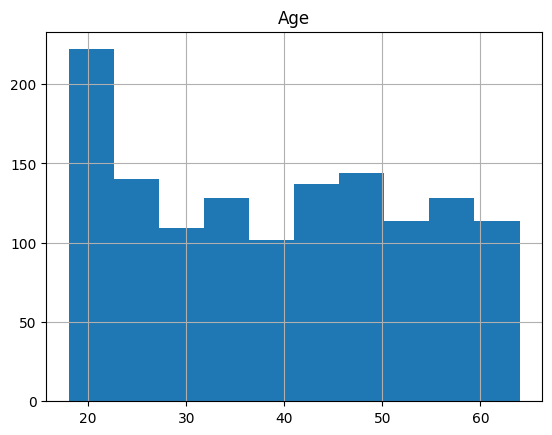

In [113]:
insurance_1['age'].hist()
plt.title('Age')
plt.show()

The distribution of age is strongly skewed towards younger population.

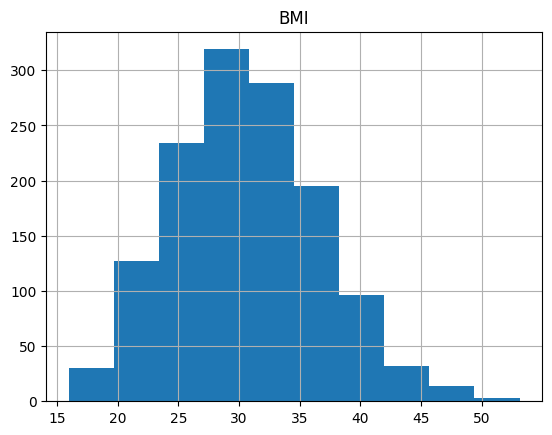

In [114]:
insurance_1['bmi'].hist()
plt.title('BMI')
plt.show()

The Body Mass Index (BMI) has a close to normal distribution around the mean.

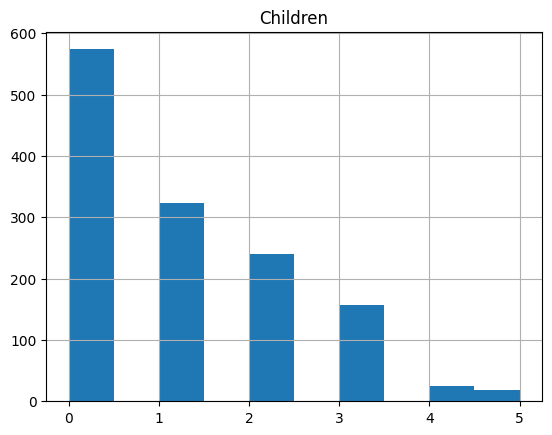

In [115]:
insurance_1['children'].hist()
plt.title('Children')
plt.show()

The distribution of the number of children is strognly skewed towards zero.

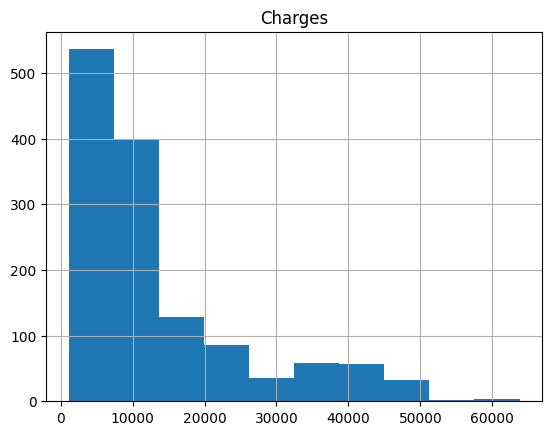

In [116]:
insurance_1['charges'].hist()
plt.title('Charges')
plt.show()

The distribution of the target variable looks skewed to the right, with amount of charge being mostly below 20k.

## Feature Selection

First we will explore the correlations among variables.

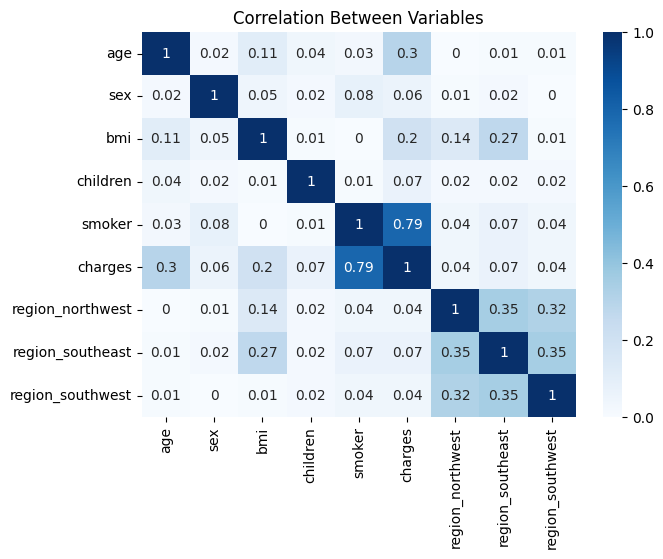

In [117]:
# Plotting the pairwise correlations' heatmap
plt.figure(figsize=(7,5))

sns.heatmap(abs(round(insurance_1.corr(), 2)), cmap='Blues', annot=True)

plt.title('Correlation Between Variables')

plt.show()

The response variable shows strong correlation with smoker, and weaker correlation with age and bmi.

We note correlation between predictors as well (age and bmi, regions and bmi).

We will use backward selection and start with linear regression model with all variables.

In [118]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [119]:
# Selecting the variables
X = insurance_1.drop(['charges'], axis=1).copy()
y = insurance_1['charges'].copy()

# Splitting the dataset in training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=700)

# Adding column for intercept
X_train['intercept'] = np.ones(X_train.shape[0])

In [120]:
# Fitting the model
model = sm.OLS(y_train, X_train)

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     456.4
Date:                Mon, 16 Oct 2023   Prob (F-statistic):               0.00
Time:                        12:23:47   Log-Likelihood:                -11483.
No. Observations:                1137   AIC:                         2.298e+04
Df Residuals:                    1128   BIC:                         2.303e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                247.9222     12.656     19.589      0.000     223.090     272.754
sex                -51.9270    353.103     -0.147      0.883    -744.740     640.886
bmi                353.1030     30.652     11.520      0.000     292.962     413.244
children           451.0647    144.753      3.116      0.002     167.049     735.081
smoker            2.392e+04    433.463     55.185      0.000    2.31e+04    2.48e+04
region_northwest  -721.8697    506.678     -1.425      0.155   -1716.006     272.267
region_southeast -1383.5478    503.535     -2.748      0.006   -2371.518    -395.578
region_southwest  -985.6499    502.525     -1.961      0.050   -1971.639       0.339
intercept        -1.193e+04   1063.190    -11.219      0.000    -1.4e+04   -9841.864
==============================================================================
Omnibus:                      242.273   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              587.664
Skew:                           1.139   Prob(JB):                    2.46e-128
Kurtosis:                       5.687   Cond. No.                         316.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on low p-value of F-statistic there is relationship between predictors and response variables, the model explains decent 76% of the response variance.

We will exclude the variable with the highest p-value (sex) and refit the model.

In [121]:
X_train_1 = X_train.drop(['sex'], axis=1)

# Refitting the model
model_1 = sm.OLS(y_train, X_train_1)

results_1 = model_1.fit()

results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     522.0
Date:                Mon, 16 Oct 2023   Prob (F-statistic):               0.00
Time:                        12:23:47   Log-Likelihood:                -11483.
No. Observations:                1137   AIC:                         2.298e+04
Df Residuals:                    1129   BIC:                         2.302e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                247.8617     12.644     19.603      0.000     223.054     272.670
bmi                353.3228     30.602     11.546      0.000     293.280     413.366
children           451.4226    144.670      3.120      0.002     167.570     735.275
smoker            2.393e+04    431.279     55.479      0.000    2.31e+04    2.48e+04
region_northwest  -721.7383    506.457     -1.425      0.154   -1715.442     271.965
region_southeast -1382.9991    503.303     -2.748      0.006   -2370.513    -395.486
region_southwest  -984.6102    502.258     -1.960      0.050   -1970.073       0.853
intercept        -1.196e+04   1040.573    -11.493      0.000    -1.4e+04   -9918.000
==============================================================================
Omnibus:                      242.291   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              587.687
Skew:                           1.139   Prob(JB):                    2.43e-128
Kurtosis:                       5.687   Cond. No.                         309.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The quality of the model in terms of fit did not deteriorate, R squared is still 0.76.

Next we will drop region_northwest variable.

In [122]:
X_train_2 = X_train_1.drop(['region_northwest'], axis=1)

# Refitting the model
model_2 = sm.OLS(y_train, X_train_2)

results_2 = model_2.fit()

results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     608.1
Date:                Mon, 16 Oct 2023   Prob (F-statistic):               0.00
Time:                        12:23:47   Log-Likelihood:                -11484.
No. Observations:                1137   AIC:                         2.298e+04
Df Residuals:                    1130   BIC:                         2.302e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                247.9818     12.649     19.604      0.000     223.163     272.801
bmi                352.7031     30.613     11.521      0.000     292.639     412.767
children           444.7500    144.660      3.074      0.002     160.917     728.583
smoker            2.395e+04    431.233     55.532      0.000    2.31e+04    2.48e+04
region_southeast -1028.3861    437.684     -2.350      0.019   -1887.151    -169.621
region_southwest  -630.1569    436.545     -1.444      0.149   -1486.687     226.373
intercept         -1.23e+04   1013.868    -12.128      0.000   -1.43e+04   -1.03e+04
==============================================================================
Omnibus:                      242.209   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              585.196
Skew:                           1.140   Prob(JB):                    8.44e-128
Kurtosis:                       5.675   Cond. No.                         297.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The quality of the fit remains the same, next we will remove region_southwest.

In [123]:
X_train_3 = X_train_2.drop(['region_southwest'], axis=1)

# Refitting the model
model_3 = sm.OLS(y_train, X_train_3)

results_3 = model_3.fit()

results_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     728.6
Date:                Mon, 16 Oct 2023   Prob (F-statistic):               0.00
Time:                        12:23:47   Log-Likelihood:                -11485.
No. Observations:                1137   AIC:                         2.298e+04
Df Residuals:                    1131   BIC:                         2.301e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                248.2189     12.654     19.615      0.000     223.390     273.047
bmi                348.5778     30.494     11.431      0.000     288.747     408.408
children           440.9597    144.706      3.047      0.002     157.038     724.882
smoker            2.396e+04    431.402     55.530      0.000    2.31e+04    2.48e+04
region_southeast  -800.7031    408.471     -1.960      0.050   -1602.150       0.743
intercept        -1.239e+04   1012.066    -12.247      0.000   -1.44e+04   -1.04e+04
==============================================================================
Omnibus:                      244.448   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              593.759
Skew:                           1.148   Prob(JB):                    1.17e-129
Kurtosis:                       5.695   Cond. No.                         296.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can also remove the remaining region variable with p-value just at 0.05.

In [124]:
X_train_4 = X_train_3.drop(['region_southeast'], axis=1)

# Refitting the model
model_4 = sm.OLS(y_train, X_train_4)

results_4 = model_4.fit()

results_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     907.6
Date:                Mon, 16 Oct 2023   Prob (F-statistic):               0.00
Time:                        12:23:47   Log-Likelihood:                -11487.
No. Observations:                1137   AIC:                         2.298e+04
Df Residuals:                    1132   BIC:                         2.301e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          248.9337     12.665     19.655      0.000     224.084     273.783
bmi          332.9212     29.466     11.298      0.000     275.107     390.735
children     440.5067    144.887      3.040      0.002     156.229     724.784
smoker       2.39e+04    431.132     55.445      0.000    2.31e+04    2.47e+04
intercept  -1.215e+04   1005.693    -12.083      0.000   -1.41e+04   -1.02e+04
==============================================================================
Omnibus:                      242.074   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              584.439
Skew:                           1.140   Prob(JB):                    1.23e-127
Kurtosis:                       5.672   Cond. No.                         294.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Residuals Analysis

We will explore the residuals for non-linearity, heteroscedasticity, and also check for high-leverage points and outliers that may distort the data.

First, we will plot the residuals vs fitted response.

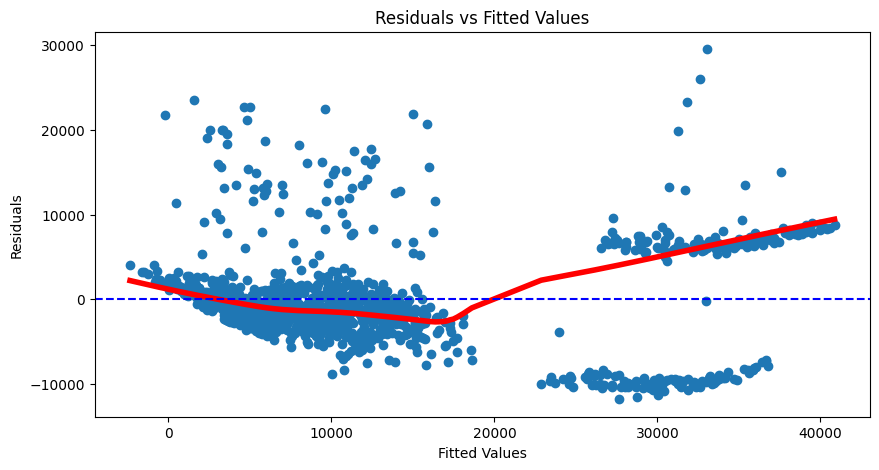

In [125]:
# Calculating lowess line
lowess = sm.nonparametric.lowess
smoothed = lowess(results_4.resid, results_4.fittedvalues)

fig, ax = plt.subplots(figsize=(10,5))

# Plotting the residuals
ax.scatter(results_4.fittedvalues, results_4.resid)

# Plotting lowess line
ax.plot(smoothed[:, 0], smoothed[:, 1], c='r', linewidth=4)

ax.axhline(0, c='b', ls='--')

ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')

ax.set_title('Residuals vs Fitted Values')

plt.show()

We can note several things:
- The residuals do not appear to be randomly distributed. There is a clear pattern, which suggests that the model has not captured all the underlying patterns in the data.
- The spread of the residuals seems to change a little across the range of fitted values, which might indicate heteroscedasticity.
- The visible pattern in the residuals might suggest that the relationship between the predictors and the response variable is non-linear.

To improve the model, first we will check for collinearity between variables and then for multicollinearity with the help of VIF.

/Users/rinatkamalov/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/Users/rinatkamalov/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/Users/rinatkamalov/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


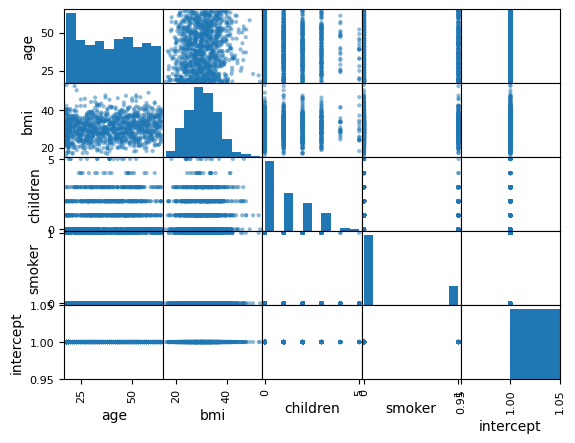

In [126]:
# Plotting pairwise scatterplots
pd.plotting.scatter_matrix(X_train_4)

plt.show()

In [127]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

vals = [VIF(X_train_4, i) for i in range(X_train_4.shape[1])]

vif = pd.DataFrame({'vif':vals},
                   index=X_train_4.columns)

vif

,vif
age,1.014109
bmi,1.013621
children,1.001301
smoker,1.000594
intercept,32.795583


VIF values does not indicate the presence of multicollinearity in the model however there seems to be some correlation between age and bmi.

We can compare the redisuals plot of the model without bmi with the previous model.

In [128]:
X_train_5 = X_train_4.drop(['bmi'], axis=1)

# Refitting the model
model_5 = sm.OLS(y_train, X_train_5)

results_5 = model_5.fit()

results_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     1050.
Date:                Mon, 16 Oct 2023   Prob (F-statistic):               0.00
Time:                        12:23:48   Log-Likelihood:                -11548.
No. Observations:                1137   AIC:                         2.310e+04
Df Residuals:                    1133   BIC:                         2.312e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          265.1444     13.268     19.984      0.000     239.112     291.177
children     475.2585    152.736      3.112      0.002     175.580     774.937
smoker      2.394e+04    454.578     52.665      0.000     2.3e+04    2.48e+04
intercept  -2649.4334    581.510     -4.556      0.000   -3790.390   -1508.476
==============================================================================
Omnibus:                      204.707   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              503.531
Skew:                           0.966   Prob(JB):                    4.57e-110
Kurtosis:                       5.626   Cond. No.                         134.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

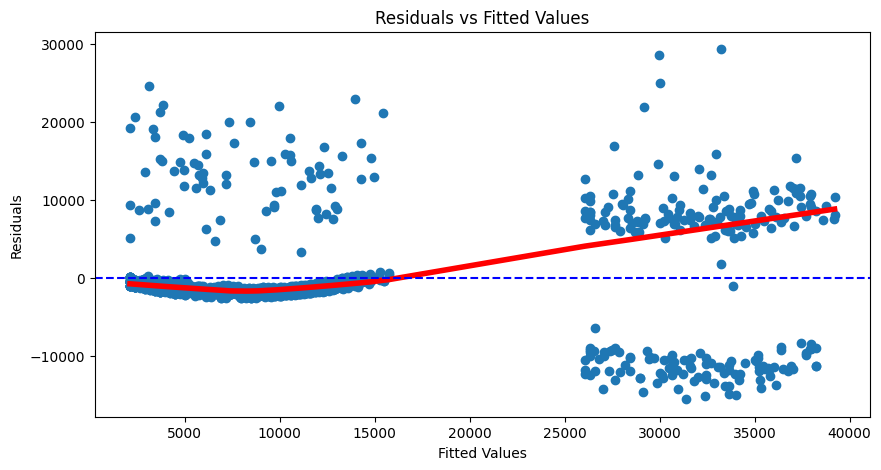

In [129]:
# Calculating lowess line
smoothed = lowess(results_5.resid, results_5.fittedvalues)

fig, ax = plt.subplots(figsize=(10,5))

# Plotting the residuals
ax.scatter(results_5.fittedvalues, results_5.resid)

# Plotting lowess line
ax.plot(smoothed[:, 0], smoothed[:, 1], c='r', linewidth=4)

ax.axhline(0, c='b', ls='--')

ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')

ax.set_title('Residuals vs Fitted Values')

plt.show()

The removal of bmi variable leads to a slight decrease in R squared, and a partial improvement of the residuals plot, especially for low amounts of charges, however there are still signs of non-linear relationship.

We will look for outliers and leverage points that might be affecting the quality of the fit.

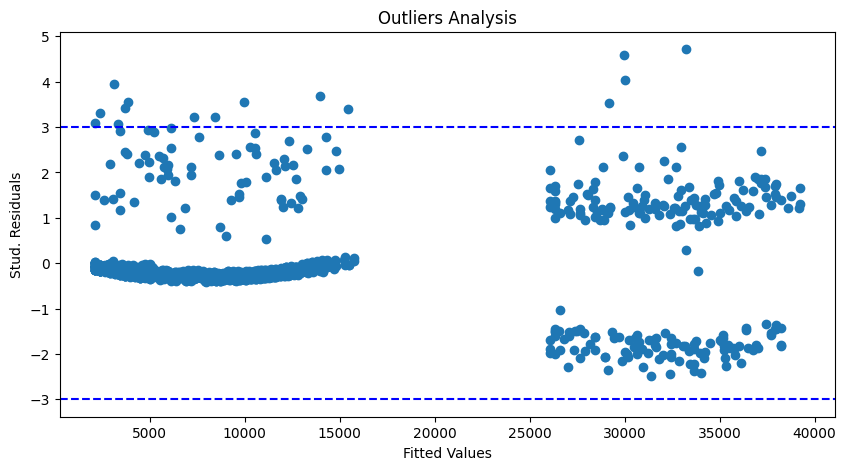

In [130]:
# Plotting the studentized residuals
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(results_5.fittedvalues, results_5.get_influence().resid_studentized)
ax.axhline(3, c='b', ls='--')
ax.axhline(-3, c='b', ls='--')

ax.set_xlabel('Fitted Values')
ax.set_ylabel('Stud. Residuals')

ax.set_title('Outliers Analysis')

plt.show()

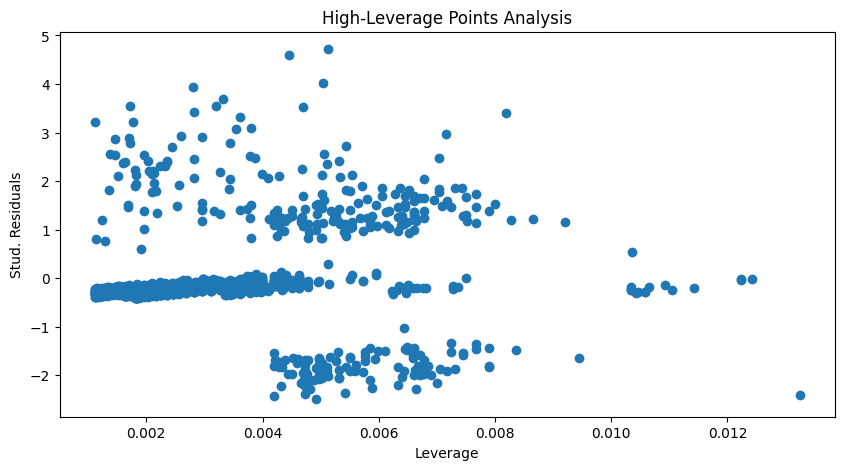

In [131]:
# Plotting the leverage points
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(results_5.get_influence().hat_matrix_diag, results_5.get_influence().resid_studentized)

ax.set_xlabel('Leverage')
ax.set_ylabel('Stud. Residuals')

ax.set_title('High-Leverage Points Analysis')

plt.show()

Given the possible numbers of outliers and high-leverage points, we will transform the model and then re-evaluate it.

First we will introduce polynomial features (except for binary categorial variable smoker) to try to capture non-linear relationship in predictors-response relationship.

In [132]:
from sklearn.preprocessing import PolynomialFeatures

# Creating 2nd degree polynomials
poly = PolynomialFeatures(degree=2).set_output(transform='pandas')
X_poly = poly.fit_transform(X[['age', 'children']])

X_poly['smoker'] = X['smoker']
X_poly.rename({'1' : 'intercept'}, axis=1, inplace=True)

# Resplitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.15, random_state=700)

X_train

,intercept,age,children,age^2,age children,children^2,smoker
556,1.0,46.0,1.0,2116.0,46.0,1.0,0
1236,1.0,63.0,0.0,3969.0,0.0,0.0,0
8,1.0,37.0,2.0,1369.0,74.0,4.0,0
110,1.0,54.0,1.0,2916.0,54.0,1.0,0
867,1.0,57.0,1.0,3249.0,57.0,1.0,0
...,...,...,...,...,...,...,...
177,1.0,54.0,1.0,2916.0,54.0,1.0,0
446,1.0,60.0,0.0,3600.0,0.0,0.0,0
1159,1.0,32.0,0.0,1024.0,0.0,0.0,0
891,1.0,36.0,4.0,1296.0,144.0,16.0,0


In [133]:
# Fitting the model with polynomial features
model_6 = sm.OLS(np.log(y_train), X_train)

results_6 = model_6.fit()

results_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     637.0
Date:                Mon, 16 Oct 2023   Prob (F-statistic):               0.00
Time:                        12:23:48   Log-Likelihood:                -677.03
No. Observations:                1137   AIC:                             1368.
Df Residuals:                    1130   BIC:                             1403.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        6.8593      0.117     58.430      0.000       6.629       7.090
age              0.0559      0.007      8.548      0.000       0.043       0.069
children         0.3049      0.045      6.808      0.000       0.217       0.393
age^2           -0.0002    8.1e-05     -2.757      0.006      -0.000   -6.45e-05
age children    -0.0040      0.001     -4.845      0.000      -0.006      -0.002
children^2      -0.0162      0.008     -2.075      0.038      -0.032      -0.001
smoker           1.5420      0.032     48.042      0.000       1.479       1.605
==============================================================================
Omnibus:                      426.728   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1662.811
Skew:                           1.787   Prob(JB):                         0.00
Kurtosis:                       7.725   Cond. No.                     1.86e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.86e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

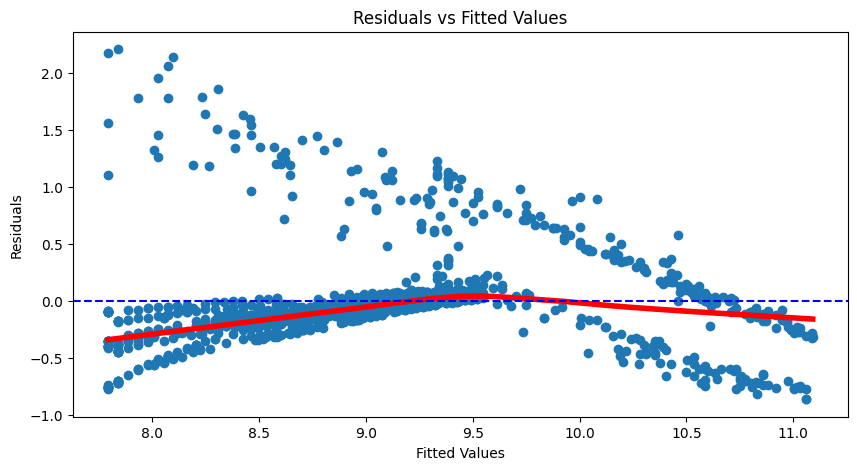

In [134]:
# Calculating lowess line
smoothed = lowess(results_6.resid, results_6.fittedvalues)

fig, ax = plt.subplots(figsize=(10,5))

# Plotting the residuals
ax.scatter(results_6.fittedvalues, results_6.resid)

# Plotting lowess line
ax.plot(smoothed[:, 0], smoothed[:, 1], c='r', linewidth=4)

ax.axhline(0, c='b', ls='--')

ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')

ax.set_title('Residuals vs Fitted Values')

plt.show()

The polyniomial model shows improved quality if fit, with flatter smoothed line. The quality of fit is better as well in terms of variance explained.

Next we will remove outliers with studentized residual values over 3, and high-leverage points.

In [135]:
st_resid3 = results_6.get_influence().resid_studentized < 3

np.sum(st_resid3)

1110

In [136]:
# Filtering out the outliers
X_train_7 = X_train[st_resid3]
y_train_7 = y_train[st_resid3]

# Refitting the model
model_7 = sm.OLS(np.log(y_train_7), X_train_7)

results_7 = model_7.fit()

results_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     1044.
Date:                Mon, 16 Oct 2023   Prob (F-statistic):               0.00
Time:                        12:23:48   Log-Likelihood:                -428.65
No. Observations:                1110   AIC:                             871.3
Df Residuals:                    1103   BIC:                             906.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        6.5726      0.097     67.910      0.000       6.383       6.763
age              0.0664      0.005     12.364      0.000       0.056       0.077
children         0.2601      0.037      7.011      0.000       0.187       0.333
age^2           -0.0003   6.65e-05     -4.831      0.000      -0.000      -0.000
age children    -0.0036      0.001     -5.214      0.000      -0.005      -0.002
children^2      -0.0089      0.006     -1.392      0.164      -0.022       0.004
smoker           1.5971      0.026     61.105      0.000       1.546       1.648
==============================================================================
Omnibus:                      281.856   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              858.139
Skew:                           1.255   Prob(JB):                    4.54e-187
Kurtosis:                       6.501   Cond. No.                     1.89e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The refitted model's R squared rose significantly reaching 0.85.

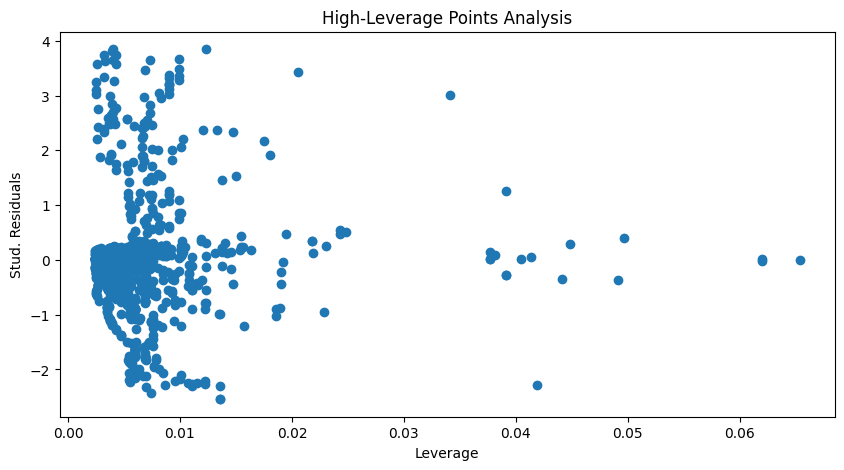

In [137]:
# Plotting the leverage points
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(results_7.get_influence().hat_matrix_diag, results_7.get_influence().resid_studentized)

ax.set_xlabel('Leverage')
ax.set_ylabel('Stud. Residuals')

ax.set_title('High-Leverage Points Analysis')

plt.show()

We will remove the observations with leverage statistic over 0.03.

In [138]:
hii_003 = results_7.get_influence().hat_matrix_diag < 0.03

np.sum(hii_003)

1092

In [139]:
# FIltering out high-leverage points
X_train_8 = X_train_7[hii_003]
y_train_8 = y_train_7[hii_003]

# Refitting the model
model_8 = sm.OLS(np.log(y_train_8), X_train_8)

results_8 = model_8.fit()

results_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     1039.
Date:                Mon, 16 Oct 2023   Prob (F-statistic):               0.00
Time:                        12:23:48   Log-Likelihood:                -422.43
No. Observations:                1092   AIC:                             858.9
Df Residuals:                    1085   BIC:                             893.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        6.5477      0.098     67.099      0.000       6.356       6.739
age              0.0676      0.005     12.434      0.000       0.057       0.078
children         0.2768      0.041      6.674      0.000       0.195       0.358
age^2           -0.0003   6.74e-05     -4.950      0.000      -0.000      -0.000
age children    -0.0041      0.001     -5.456      0.000      -0.006      -0.003
children^2      -0.0085      0.009     -0.901      0.368      -0.027       0.010
smoker           1.6017      0.026     61.049      0.000       1.550       1.653
==============================================================================
Omnibus:                      276.896   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              837.475
Skew:                           1.255   Prob(JB):                    1.40e-182
Kurtosis:                       6.480   Cond. No.                     1.89e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model still shows good R squared over 0.85. We will exclude the variable with p-value over 0.05 (children^2).

In [140]:
X_train_9 = X_train_8.drop(['children^2'], axis=1)

# Fitting the model with polynomial features
model_9 = sm.OLS(np.log(y_train_8), X_train_9)

results_9 = model_9.fit()

results_9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     1247.
Date:                Mon, 16 Oct 2023   Prob (F-statistic):               0.00
Time:                        12:23:48   Log-Likelihood:                -422.84
No. Observations:                1092   AIC:                             857.7
Df Residuals:                    1086   BIC:                             887.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        6.5374      0.097     67.463      0.000       6.347       6.728
age              0.0685      0.005     12.825      0.000       0.058       0.079
children         0.2526      0.032      7.992      0.000       0.191       0.315
age^2           -0.0003   6.62e-05     -5.203      0.000      -0.000      -0.000
age children    -0.0041      0.001     -5.497      0.000      -0.006      -0.003
smoker           1.6021      0.026     61.074      0.000       1.551       1.654
==============================================================================
Omnibus:                      276.865   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              837.726
Skew:                           1.255   Prob(JB):                    1.23e-182
Kurtosis:                       6.481   Cond. No.                     1.88e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.88e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

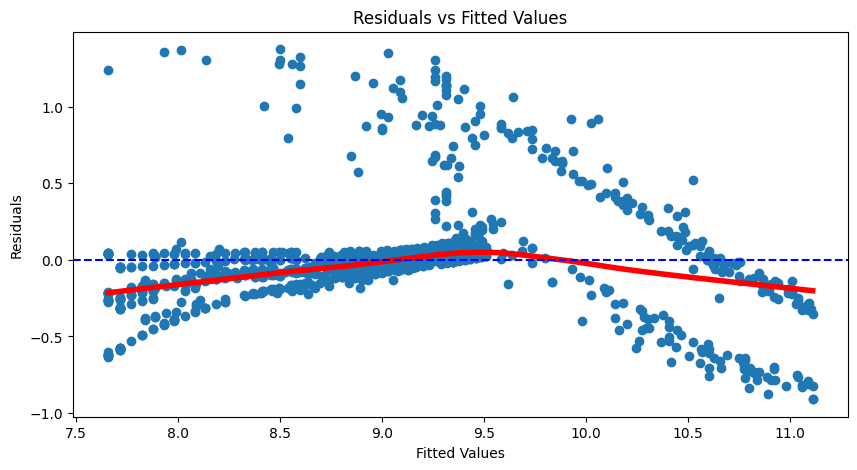

In [141]:
# Calculating lowess line
smoothed = lowess(results_9.resid, results_9.fittedvalues)

fig, ax = plt.subplots(figsize=(10,5))

# Plotting the residuals
ax.scatter(results_9.fittedvalues, results_9.resid)

# Plotting lowess line
ax.plot(smoothed[:, 0], smoothed[:, 1], c='r', linewidth=4)

ax.axhline(0, c='b', ls='--')

ax.set_xlabel('Fitted Values')
ax.set_ylabel('Residuals')

ax.set_title('Residuals vs Fitted Values')

plt.show()

The residuals are more randomly dispersed around the horizontal line, suggesting that the model is now capturing a greater extent of the underlying patterns in the data.

The spread of residuals appears more constant across different levels of fitted values, indicating a reduction in heteroscedasticity.

The absence of a clear pattern in the residuals suggests that non-linearity issues have been addressed to some extent.

We can additionally check for normality of residuals using QQ plot.

<Figure size 500x500 with 0 Axes>

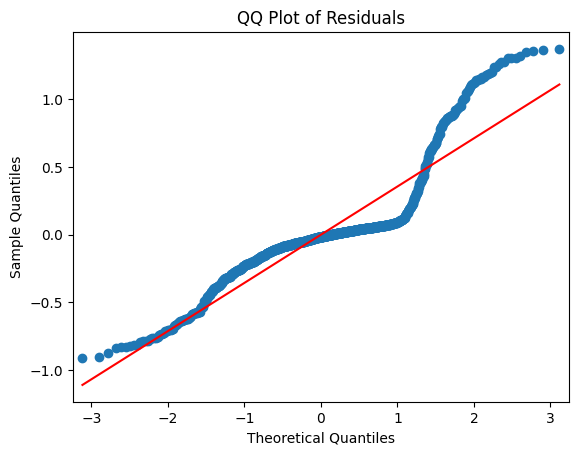

In [143]:
# Plotting QQ plot of the improved residuals
plt.figure(figsize=(5, 5))

sm.graphics.qqplot(results_9.resid, line='s')

plt.title('QQ Plot of Residuals')

plt.show()

The points in the low and central sections of the plot are closely aligned with the theoretical line, indicating that the main portion of the residuals is approximately normally distributed.

Now we will check the predictive power of the polynomial model on test data.

## Model Evaluation

In [144]:
X_test_1 = X_test.drop(['children^2'], axis=1)

predictions = results_9.get_prediction(X_test_1)

y_predict = predictions.predicted_mean

In [145]:
from sklearn.metrics import r2_score

In [146]:
# Calculating R squared
R2_test = r2_score(np.log(y_test), y_predict)

print(' R squared:', round(R2_test, 2))

 R squared: 0.71


Our 2nd degree polynomial model shows decent accuracy on new data, and can be expected to explain around 71% of the target variable variance.

# Conclusion

In this analysis, our focus was to unravel the complex relationship between individual characteristics and medical costs, utilizing a detailed dataset. We aimed to construct a predictive model that could accurately estimate individual medical bills, a tool of significant value to hospitals for financial planning and resource allocation. The approach involved an in-depth exploration of the dataset, with a particular emphasis on variables like age, number of children, and smoking status, and employing a linear regression model enhanced with polynomial features and log transform of the response to optimize predictions.

Our findings revealed a marked improvement in prediction accuracy with the integration of second-degree polynomial features, addressing initial challenges of heteroscedasticity and non-linearity. The final model, evaluated on test data, yielded a commendable R-squared value of 0.71, which underscores the model's effectiveness in capturing a significant portion of the variance in medical costs and its precision in estimation. While the model is robust, we recognize the continual need for refinement and adaptation to broader and more diverse datasets to enhance its applicability and accuracy further.